### SEGMENT ANYTHING MODEL (META)

https://huggingface.co/facebook/sam-vit-base

**IMPORTS**

In [1]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path, get_checkpoint_path, get_all_files_from_folder, DATASET_PATH_TYPE
from src.utils.augmentation import erase_generator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

**INSTALLS**

In [ ]:
# %pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# %pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [9]:
CHECKPOINT_PATH = get_checkpoint_path("sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

In [10]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=0.5,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [31]:
relative_path = get_training_data_path('classifier', 'pant')
file_names = load_images(relative_path)

for file_name in file_names:
    fullpath = os.path.join(relative_path, file_name)
    n_image, blurred_image = process_image(fullpath)
    cleaned_masks = generate_masks(blurred_image)
    
    if not cleaned_masks:
        continue
    
    final_annotated_image = annotate_images(n_image, blurred_image, cleaned_masks)
    masks_cleaned = clean_masks(cleaned_masks)
    
    if masks_cleaned:
        crop_and_save_mask(masks_cleaned, n_image, file_name.split('.')[0])
    
    plot_images([n_image, final_annotated_image], ['source image', 'segmented image'], grid_size=(1, 2))


[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 12541, 'bbox': [123, 14, 87, 218], 'predicted_iou': 0.9749383926391602, 'point_coords': [[175.00000000000003, 125.0]], 'stability_score': 0.9592809677124023, 'crop_box': [0.0, 0.0, 250.0, 250.0]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 13464, 'bbox': [47, 17, 81, 218], 'predicted_iou': 0

KeyboardInterrupt: 

In [3]:
files = get_all_files_from_folder('./blueprints')
blueprint_masks = []
for file in files:
    fullpath = './blueprints/' + file
    mask = cv2.imread(fullpath, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
    blueprint_masks.append(mask)

In [6]:
import random

def compute_overlap(mask1, mask2):
    # Compute the overlapping area between two binary masks
    overlap = np.sum((mask1 == 255) & (mask2 == 255))
    return overlap

def find_best_rotation(input_mask, blueprint_mask, angle_step=1):
    best_angle = 0
    max_overlap = 0
    
    for angle in range(0, 360, angle_step):
        # Rotate the input mask
        rotated_mask = rotate_image(input_mask, angle)
        
        # Compute the overlap with the blueprint mask
        overlap = compute_overlap(rotated_mask, blueprint_mask)
        if overlap > max_overlap:
            max_overlap = overlap
            best_angle = angle
    
    #print(f"Best mask: {blueprint_mask[0]}")
    return [max_overlap, best_angle]

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST)
    return rotated



def plot_before_after_rotations(rotated_masks, original_image, num_rows=18):
    # fig, axs = plt.subplots(num_rows, 4, figsize=(16, num_rows * 3))
    # plt.subplots_adjust(hspace=0.0, wspace=0.0)  # Reduce padding between subplots

    # for i in range(num_rows):
    #     line_ax = fig.add_subplot(num_rows, 1, i + 1, frame_on=False)
    #     line_ax.plot([0.5, 0.5], [0, 1], transform=fig.transFigure, color='red', linestyle='--')
    #     line_ax.axis('off')  # Turn off the axis

    random_angle = random.uniform(0, 360)
    tester = rotate_image(original_image, random_angle)
    angles = []
    for blueprint_mask in blueprint_masks:
        blueprint_mask = cv2.resize(blueprint_mask, (256, 256))
        best_angle = find_best_rotation(tester, blueprint_mask)
        angles.append(best_angle)
    best_angle_final = np.max(angles, axis=0)[1]

    print(best_angle_final)
    #aligned_image = rotate_image(tester, best_angle_final)
        
        # row = i // 2
        # col = (i % 2) * 2
        
        # axs[row, col].imshow(tester, cmap='gray')
        # axs[row, col].set_title(f'Before Rotation {i*10}°')
        # axs[row, col].axis('off')

        # axs[row, col + 1].imshow(aligned_image, cmap='gray')
        # axs[row, col + 1].set_title(f'After Best Rotation {best_angle_final}°')
        # axs[row, col + 1].axis('off')

    # plt.tight_layout()
    # plt.savefig(f'./plots/{file_name}')


def get_best_angle_overlaps(image):
    random_angle = random.uniform(0, 360)
    tester = rotate_image(image, random_angle)
    angles = []
    for blueprint_mask in blueprint_masks:
        blueprint_mask = cv2.resize(blueprint_mask[1], (256, 256))
        best_angle = find_best_rotation(tester, blueprint_mask)
        angles.append(best_angle)
    best_angle_final = np.max(angles, axis=0)[1]
    return best_angle_final

34
Mean Absolute Error: 85.34°
Standard Deviation of Error: 53.03°


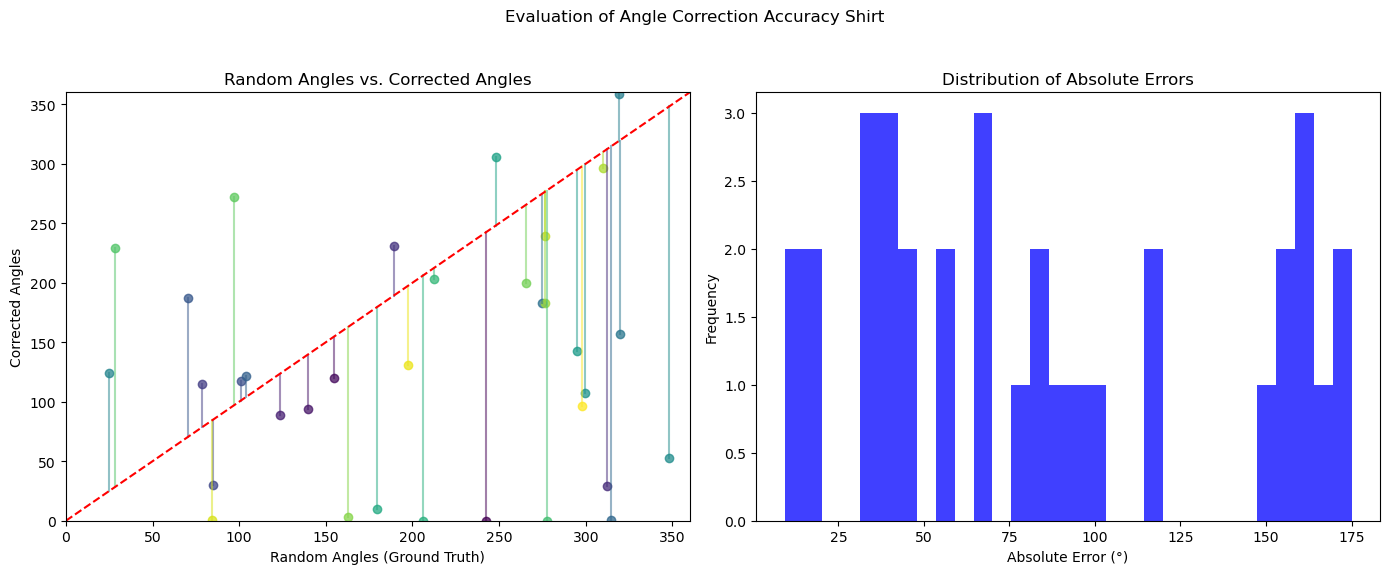

In [7]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

# Assuming rotate_image and find_contours_and_extreme_points are already defined

path = get_training_data_path('masks', 'shirt')
files = get_all_files_from_folder(path)
print(len(files))
res = []

for file in files:
    fullpath = os.path.join(path, file)
    random_angle = random.uniform(0, 360)
    img = cv2.imread(fullpath)
    alpha_channel = img[:, :, 2]
    img = (alpha_channel > 0).astype(np.uint8) * 255
    corrected_angle = get_best_angle_overlaps(img)
    res.append([random_angle, corrected_angle])

# Convert to numpy array for easier manipulation
res = np.array(res)
random_angles = res[:, 0]
corrected_angles = res[:, 1]

# Compute absolute errors
errors = np.abs(random_angles - corrected_angles)
errors = np.minimum(errors, 360 - errors)  # Account for circular nature of angles

# Calculate summary statistics
mean_error = np.mean(errors)
std_error = np.std(errors)

# Print summary statistics
print(f'Mean Absolute Error: {mean_error:.2f}°')
print(f'Standard Deviation of Error: {std_error:.2f}°')

# Assign unique colors to each pair
colors = plt.cm.viridis(np.linspace(0, 1, len(random_angles)))

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot of random angles vs. corrected angles with pair-wise colors and lines
for i in range(len(random_angles)):
    ax[0].scatter(random_angles[i], corrected_angles[i], color=colors[i], alpha=0.75)
    ax[0].plot([random_angles[i], random_angles[i]], [random_angles[i], corrected_angles[i]], color=colors[i], alpha=0.5, linestyle='-')

ax[0].plot([0, 360], [0, 360], color='red', linestyle='--')  # Perfect correlation line
ax[0].set_xlabel('Random Angles (Ground Truth)')
ax[0].set_ylabel('Corrected Angles')
ax[0].set_title('Random Angles vs. Corrected Angles')
ax[0].set_xlim([0, 360])
ax[0].set_ylim([0, 360])

# Histogram of errors
ax[1].hist(errors, bins=30, alpha=0.75, color='blue')
ax[1].set_xlabel('Absolute Error (°)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Absolute Errors')

plt.suptitle('Evaluation of Angle Correction Accuracy Shirt')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
